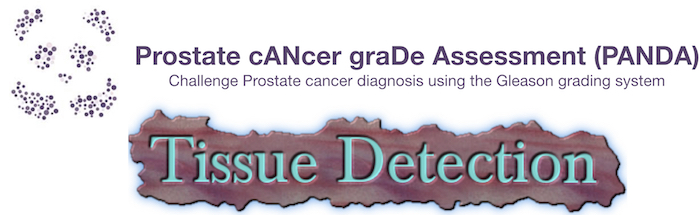

Tissue Detection is a key aspect to research in the domain of computer vision applied to cancer classification. My main focus in this competition so far has been exploring previous work done in this domain and furthering its application towards this dataset. Notebooks in this collection include the following.
* [Base Notebook](https://www.kaggle.com/dannellyz/panda-tissue-detection-size-optimization-70) : Tissue Detection Intro and First Application
* [Base Dataset Generation](https://www.kaggle.com/dannellyz/tissue-detect-td-conv-png-512x512): Notebook to export images to zip file
* [Scaling Bounding Boxes **(Currently Here)**](https://www.kaggle.com/dannellyz/tissue-detect-scaling-bounding-boxes-4xfaster): 4x speed increase to base notebook
* [Tissue Dection Metadata Analysis](https://www.kaggle.com/dannellyz/tissue-detection-bounding-box-metadata-eda-viz/): Exploring features from bounding boxes discovery on the slides

# PANDA Tissue Detect: Scaling Bounding Boxes

I started my research in this competition by taking academic papers and applying their technique to discover tissue within the provided Whole Slide Images. The notebook I created, [Tissue Detection and Size Optimization ~70% Shrink](https://www.kaggle.com/dannellyz/panda-tissue-detection-size-optimization-70/), walked through the steps of my process, but focused only on the highest level downsampled images (least resolution). I made another [notebook that exported these images](https://www.kaggle.com/dannellyz/tissue-detect-png-512x512-pre-process) as (512x512), however, after completing this I realized that the resolutions on the images were not quite up to what I wanted.

This notebook started with running my pipeline on larger images and realizing that the time it took was unmanageable. Therefore, I edited the pipeline to speed up processing. I did this by detecting min-area-rect bounding boxes around tissue samples on the low resolution images and scaling that box up the larger images. After this croping the image by the bounding box and then cutting out the empty space. This is all then followed by re-sizing the image to the export shape and finally re-detecting the tissue on the larger slide to remove the background.

## This method increased my image pre-processing speed by 4 times

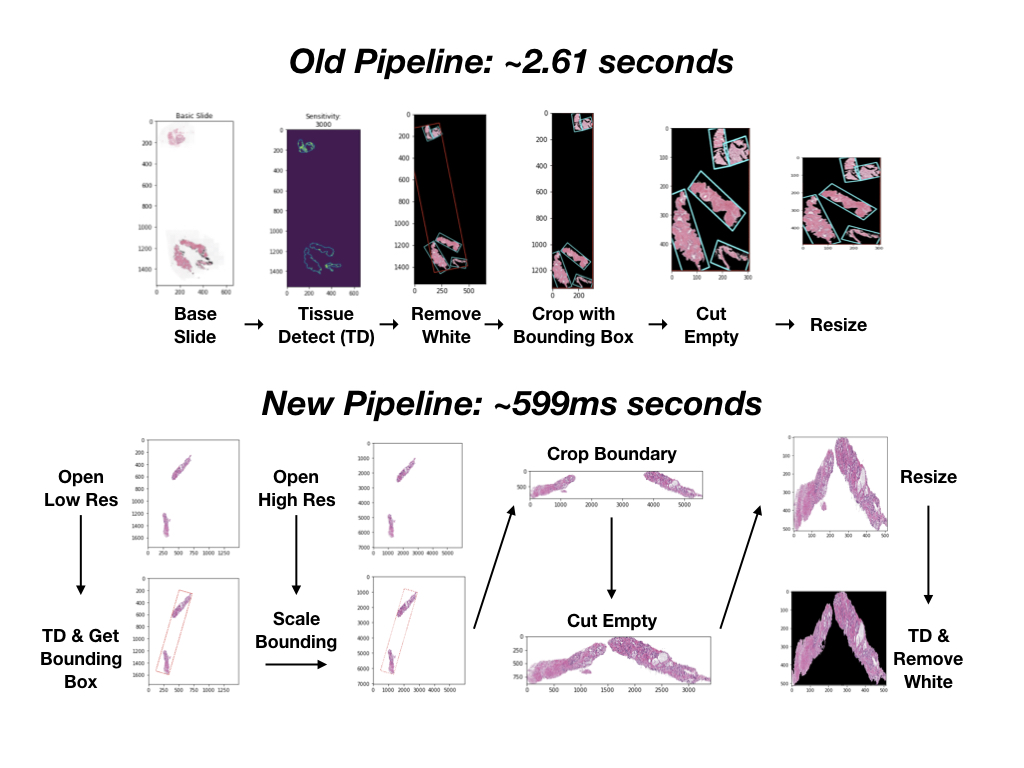

In [ ]:
# All imports
import time

import matplotlib.pyplot as plt
import numpy as np
import openslide
import pandas as pd
import skimage.io
from skimage import morphology
import pprint
import cv2
import json


def otsu_filter(channel, gaussian_blur=True):
    
    """Otsu filter."""
    
    if gaussian_blur:
        channel = cv2.GaussianBlur(channel, (5, 5), 0)
    channel = channel.reshape((channel.shape[0], channel.shape[1]))

    return cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def detect_tissue(input_slide, sensitivity=3000):
    
    """
    Description
    ----------
    Find RoIs containing tissue in WSI.
    Generate mask locating tissue in an WSI. Inspired by method used by
    Wang et al. [1]_.
    .. [1] Dayong Wang, Aditya Khosla, Rishab Gargeya, Humayun Irshad, Andrew
    H. Beck, "Deep Learning for Identifying Metastatic Breast Cancer",
    arXiv:1606.05718
    Credit: Github-wsipre
    
    Parameters
    ----------
    input_slide: numpy array
        Slide to detect tissue on.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 3000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
        
    Returns (3)
    -------
    -Tissue binary mask as numpy 2D array, 
    -Tiers investigated,
    -Time Stamps from running tissue detection pipeline
    """
    
    # For timing
    time_stamps = {}
    time_stamps["start"] = time.time()

    # Convert from RGB to HSV color space
    slide_hsv = cv2.cvtColor(input_slide, cv2.COLOR_BGR2HSV)
    time_stamps["re-color"] = time.time()
    # Compute optimal threshold values in each channel using Otsu algorithm
    _, saturation, _ = np.split(slide_hsv, 3, axis=2)

    mask = otsu_filter(saturation, gaussian_blur=True)
    time_stamps["filter"] = time.time()
    # Make mask boolean
    mask = mask != 0

    mask = morphology.remove_small_holes(mask, area_threshold=sensitivity)
    mask = morphology.remove_small_objects(mask, min_size=sensitivity)
    time_stamps["morph"] = time.time()
    mask = mask.astype(np.uint8)
    mask_contours, tier = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    time_stamps["contour"] = time.time()
    time_stamps = {
        key: (value - time_stamps["start"]) * 1000 for key, value in time_stamps.items()
    }
    return mask_contours, tier, time_stamps


def draw_tissue_polygons(input_slide, tissue_contours, plot_type, line_thickness=None):
    
    """
    Description
    ----------
    Plot Tissue Contours as numpy array on.
    Credit: Github-wsipre

    Parameters
    ----------
    input_slide: numpy array
        Slide to draw contours onto
    tissue_contours: numpy array 
        These are the identified tissue regions as cv2 contours
    plot_type: str ("line" | "area")
        The desired display type for the tissue regions
    line_thickness: int
        If the polygon_type=="line" then this parameter sets thickness

    Returns (1)
    -------
    - Numpy array of tissue mask plotted
    """

    tissue_color = 1

    for cnt in tissue_contours:
        if plot_type == "line":
            output_slide = cv2.polylines(input_slide, [cnt], True, tissue_color, line_thickness)
        elif plot_type == "area":
            if line_thickness is not None:
                warnings.warn(
                    '"line_thickness" is only used if ' + '"polygon_type" is "line".'
                )

            output_slide = cv2.fillPoly(input_slide, [cnt], tissue_color)
        else:
            raise ValueError('Accepted "polygon_type" values are "line" or "area".')

    return output_slide


def tissue_cutout(input_slide, tissue_contours):
    
    """
    Description
    ----------
    Set all parts of the in_slide to black except for those
    within the provided tissue contours
    Credit: https://stackoverflow.com/a/28759496
    
    Parameters
    ----------
    input_slide: numpy array
            Slide to cut non-tissue backgound out
    tissue_contours: numpy array 
            These are the identified tissue regions as cv2 contours
            
    Returns (1)
    -------
    - Numpy array of slide with non-tissue set to black
    """
    
    # Get intermediate slide
    base_slide_mask = np.zeros(input_slide.shape[:2])
    
    # Create mask where white is what we want, black otherwise
    crop_mask = np.zeros_like(base_slide_mask) 
    
    # Draw filled contour in mask
    cv2.drawContours(crop_mask, tissue_contours, -1, 255, -1) 
    
    # Extract out the object and place into output image
    tissue_only_slide = np.zeros_like(input_slide)  
    tissue_only_slide[crop_mask == 255] = input_slide[crop_mask == 255]
    
    return tissue_only_slide


def getSubImage(input_slide, rect):
    
    """
    Description
    ----------
    Take a cv2 rectagle object and remove its contents from
    a source image.
    Credit: https://stackoverflow.com/a/48553593
    
    Parameters
    ----------
    input_slide: numpy array 
            Slide to pull subimage off 
    rect: cv2 rect
        cv2 rectagle object with a shape of-
            ((center_x,center_y), (hight,width), angle)
    
    Returns (1)
    -------
    - Numpy array of rectalge data cut from input slide
    """
    
    width = int(rect[1][0])
    height = int(rect[1][1])
    box = cv2.boxPoints(rect)

    src_pts = box.astype("float32")
    dst_pts = np.array(
        [[0, height - 1], [0, 0], [width - 1, 0], [width - 1, height - 1]],
        dtype="float32",
    )
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    output_slide = cv2.warpPerspective(input_slide, M, (width, height))
    return output_slide


def color_cut(in_slide, color = [255,255,255]):
    
    """
    Description
    ----------
    Take a input image and remove all rows or columns that
    are only made of the input color [R,G,B]. The default color
    to cut from image is white.
    
    Parameters
    ----------
    input_slide: numpy array 
        Slide to cut white cols/rows 
    color: list
        List of [R,G,B] pixels to cut from the input slide
    
    Returns (1)
    -------
    - Numpy array of input_slide with white removed
    """
    #Remove by row
    row_not_blank = [row.all() for row in ~np.all(in_slide == color, axis=1)]
    output_slide = in_slide[row_not_blank, :]
    
    #Remove by col
    col_not_blank = [col.all() for col in ~np.all(output_slide == color, axis=0)]
    output_slide = output_slide[:, col_not_blank]
    return output_slide

def detect_and_crop(image_location,sensitivity= 3000,downsample_lvl= -1,show_plots= "simple"):
    
    """
    Description
    ----------
    This method performs the pipeline as described in the notebook:
    https://www.kaggle.com/dannellyz/panda-tissue-detection-size-optimization-70
    
    Parameters
    ----------
    image_location:str
        Location of the slide image to process
    sensitivity:int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 3000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
    downsample_lvl: int
        The level at which to downsample the slide. This can be referenced in
        reverse order to access the lowest resoltuion items first.
        [-1] = lowest resolution
        [0] = highest resolution
    show_plots: str (verbose|simple|none)
        The types of plots to display:
            - verbose - show all steps of process
            - simple - show only last step
            - none - show none of the plots
        
    Returns (4)
    -------
    - Numpy array of final produciton(prod) slide
    - Percent memory reduciton from original slide
    - Time stamps from stages of the pipeline
    - Time stamps from the Tissue Detect pipeline
    """

    # For timing
    time_stamps = {}
    time_stamps["start"] = time.time()

    # Open Slide
    wsi = skimage.io.MultiImage(image_location)[downsample_lvl]
    time_stamps["open"] = time.time()

    # Get returns from detect_tissue()
    (
        tissue_contours,
        tier,
        time_stamps_detect,
    ) = detect_tissue(wsi, sensitivity)
    time_stamps["tissue_detect"] = time.time()
    # Get Tissue Only Slide
    base_slide_mask = np.zeros(wsi.shape[:2])
    tissue_slide = draw_tissue_polygons(base_slide_mask, tissue_contours, "line", 5)
    tissue_only_slide = tissue_cutout(wsi, tissue_contours)
    time_stamps["tissue_trim"] = time.time()
    # Get minimal bounding rectangle for all tissue contours
    if len(tissue_contours) == 0:
        img_id = image_location.split("/")[-1]
        print(f"No Tissue Contours - ID: {img_id}")
        return None, 1.0

    all_bounding_rect = cv2.minAreaRect(np.concatenate(tissue_contours))
    # Crop with getSubImage()
    smart_bounding_crop = getSubImage(tissue_only_slide, all_bounding_rect)
    time_stamps["crop"] = time.time()
    
    #cut empty space
    prod_slide = color_cut(smart_bounding_crop, [0,0,0])
    time_stamps["trim_white"] = time.time()

    # Get size change
    base_size = get_disk_size(wsi)
    final_size = get_disk_size(prod_slide)
    pct_change = final_size / base_size
    if show_plots == "simple":
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plt.imshow(smart_bounding_crop)
        plt.show()
    elif show_plots == "verbose":
        # Set-up dictionary for plotting
        verbose_plots = {}
        # Add Base Slide to verbose print
        verbose_plots[f"Base Slide\n{get_disk_size(wsi):.2f}MB"] = wsi
        # Add Tissue Only to verbose print
        verbose_plots[f"Tissue Detect\nNo Change"] = tissue_slide
        # Add Bounding Boxes to verbose print
        verbose_plots[
            f"Bounding Boxes\n{get_disk_size(smart_bounding_crop):.2f}MB"
        ] = smart_bounding_crop
        # Add Cut Slide to verbose print
        verbose_plots[
            f"Cut Slide\n{get_disk_size(prod_slide):.2f}MB"
        ] = prod_slide
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plot_figures(verbose_plots, 2, 2)
    elif show_plots == "none":
        pass
    else:
        pass
    time_stamps = {
        key: (value - time_stamps["start"]) * 1000 for key, value in time_stamps.items()
    }
    return prod_slide, (1 - pct_change), time_stamps, time_stamps_detect


def get_disk_size(numpy_image):
    """Return disk size of a numpy array"""
    return (numpy_image.size * numpy_image.itemsize) / 1000000


def plot_figures(figures, nrows=1, ncols=1):
    
    """
    Description
    ----------
    Plot a dictionary of figures.
    Credit: https://stackoverflow.com/a/11172032

    Parameters
    ----------
    figures: dict 
        <title, figure> for those to plot
    ncols: int 
        number of columns of subplots wanted in the display
    nrows: int 
        number of rows of subplots wanted in the figure
    
    Returns(0)
    ----------
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], aspect="auto")
        axeslist.ravel()[ind].set_title(title)
    plt.tight_layout()
    plt.show()
    return 


def get_timings(time_stamp_dict, verbose = False):
    """
    Description
    ----------
    Get timing defferentials and percentages from a dictionary of timestamps 
    
    Parameters
    ----------
    time_stamp_dict: dict
        <description:time> for each of the measured time points
        
    Returns (2)
    -------
    - Dictionary with the time differentials at each time point
    - Dictionary with the time percentages for each point compared to total
    """
    
    time_diffs = {}
    dict_list = list(time_stamp_dict.items())
    for i in range(len(dict_list) - 1):
        time_diffs[dict_list[i + 1][0]] = dict_list[i + 1][1] - dict_list[i][1]
    total_time = list(time_stamp_dict.values())[-1]
    time_pcts = {k: v / (total_time + 0.0001) for k, v in time_diffs.items()}
    if verbose:
        print(f"Total Between Funcitons:")
        print(json.dumps(time_diffs, indent=4))
        print(f"Pct Between Funcitons:")
        print(json.dumps(time_pcts, indent=4))
        print(f"Timing Totals:")
        print(json.dumps(time_stamp_dict, indent=4))
    return time_diffs, time_pcts

def comp_timings(time_stamp_low, time_stamp_high, verbose=False):
    """
    Description
    ----------
    Take two timestamp dictionaries and compare them.
    
    Parameters
    ----------
    time_stamp_low: dict
        <description:time> for each of the measured time points (shorter process)
    time_stamp_high: dict
        <description:time> for each of the measured time points (longer process)
    
    Returns (1)
    -------
    - Dictionary with the raw differences between the two dicts
    - Dictionary with the percentage differences between the two dicts
    """
    
    raw_comp = {k:time_stamp_high[k]-time_stamp_low[k] for k,v in time_stamp_low.items()}
    pct_comp = {k:time_stamp_low[k]/time_stamp_high[k] for k,v in time_stamp_low.items()}
    if verbose:
        print(f"Timing Diffs Raw (High - Low):")
        print(json.dumps(raw_comp, indent=4))
        print(f"Timing: Diffs Pct (Low / High):")
        print(json.dumps(pct_comp, indent=4))
    return raw_comp, pct_comp
    

### ↑ Pipeline Code Hidden Above ↑

A full explaination of the pipeline is documented in the above mentioned [notebook](https://www.kaggle.com/dannellyz/panda-tissue-detection-size-optimization-70/). 

# Timings: Running Pipeline on Lowest Resolution 
This is the highest indexed downsample level therefore referenced with [-1]. All times are in milliseconds.

In [ ]:
# Set up example slide and run pipeline on low resolution
slide_dir = "../input/prostate-cancer-grade-assessment/train_images/"
annotation_dir = "../input/prostate-cancer-grade-assessment/train_label_masks/"
example_id = "0032bfa835ce0f43a92ae0bbab6871cb"
example_slide = f"{slide_dir}{example_id}.tiff"
(processed_slide_low, pct_change_low, 
time_stamps_pipeline_low, detect_time_low) = detect_and_crop(
                                image_location=example_slide, 
                                downsample_lvl=-1, 
                                show_plots="verbose"
                                )
print("Pipeline Timings: Low")
pipe_times_low, pipe_time_pct_low = get_timings(time_stamps_pipeline_low, verbose=True)
print("-"*30)
print("Tissue Detect Timings: Low")
tiss_times_low, tiss_time_pct_low = get_timings(detect_time_low, verbose=True)

## Findings:
* Tissue Detection encompasses almost 60% of the pre-processing time
* Opening and Cutting the files are next most costly at about 12% each

# Timings: Running Pipeline on Medium Resolution 
Index of [-2] in the level array. We also know that the provided images only have three layers of downsampling (1.0,4.0,16.0). This is to say that the image processed here is 4x bigger in both dimensions than the previous image. Therefore making the ratio 1/16.

In [ ]:
(processed_slide_med, pct_change_med, 
 time_stamps_pipeline_med, detect_time_med) = detect_and_crop(
                                        image_location=example_slide, 
                                        downsample_lvl=-2, show_plots="verbose"
                                        )

print("Pipeline Timings: Med")
pipe_times_med, pipe_time_pct_med = get_timings(time_stamps_pipeline_med, verbose=True)
print("-"*30)
print("Tissue Detect Timings: Med")
tiss_times_med, tiss_time_pct_med = get_timings(detect_time_med, verbose=True)

## Findings:
* Tissue Detect timings increase proportionally linear with the size of the image.
* Opening the image takes a slightly higher proportionate time.
* Since Tissue Detect is the majority, the overall time increases proportionally

In [ ]:
print("Pipeline Timings: Med")
pipe_times_comp, pipe_time_pct_comp = comp_timings(pipe_times_low, pipe_times_med,verbose=True)
print("-"*30)
print("Tissue Detect Timings: Med")
tiss_times_comp, tiss_time_pct_comp = comp_timings(tiss_times_low,tiss_times_med,verbose=True)
print("-"*30)
print(f"Processed Size Ratio: {processed_slide_low.size / processed_slide_med.size}")
time_full_low, time_full_med = time_stamps_pipeline_low["crop"], time_stamps_pipeline_med["crop"]
print(f"Processed Time Ratio: {time_full_low / time_full_med}")


# New Pipeline Analysis

Given that so much of the time it takes to process the images comes from the Tissue Detection the new pipeline seeks to handle that portion on the lowest resolution then scale up the resulting bounding boxes to the high resolution images. Then to cut the large image down as much as possible before re-runing the tissue detect on the higher resolution. Below is a step through of this process.

## Open low resolution image

In [ ]:
# Open slide on lowest resolution
low_res_lvl = -1
img_low = skimage.io.MultiImage(example_slide)[low_res_lvl]
plt.imshow(img_low)
plt.show()


## Detect Tissue and Find Bounding Boxes

In [ ]:
# Detect Tissue and 
(
    tissue_contours,
    tier,
    time_stamps_detect,
) = detect_tissue(img_low)

# Copy for compare
smart_bounding_boxes = img_low.copy()

# Get small level bounding boxes
all_bounding_rect = cv2.minAreaRect(np.concatenate(tissue_contours))
all_bounding_box = cv2.boxPoints(all_bounding_rect)
all_bounding_box = np.int0(all_bounding_box)
cv2.drawContours(smart_bounding_boxes, [all_bounding_box], 0, (255, 0, 0), 4)
plt.imshow(smart_bounding_boxes)
plt.show()

## Open High Resolution Image

In [ ]:
# Open slide on lowest resolution
high_res_lvl = -2
img_high = skimage.io.MultiImage(example_slide)[high_res_lvl]
plt.imshow(img_high)
plt.show()

## Scale Smaller Bounding Boxes to High Res Image

In [ ]:
smart_scale = img_high.copy()
scale = 4
# Get center, size, and angle from rect
scaled_rect = (
    (all_bounding_rect[0][0] * scale, all_bounding_rect[0][1] * scale),
    (all_bounding_rect[1][0] * scale, all_bounding_rect[1][1] * scale),
    all_bounding_rect[2],
)
scaled_bounding_box = cv2.boxPoints(scaled_rect)
scaled_bounding_box = np.int0(scaled_bounding_box)
cv2.drawContours(smart_scale, [scaled_bounding_box], 0, (255, 0, 0), 10)
plt.imshow(smart_scale)
plt.show()

## Crop High Res Image with Bounding Box

In [ ]:
scaled_smart_crop = getSubImage(smart_scale, scaled_rect)
plt.imshow(scaled_smart_crop)
plt.show()

## Crop White Space From Image

In [ ]:
big_slide_cut = color_cut(scaled_smart_crop, color=[255,255,255])
plt.imshow(big_slide_cut)
plt.show()

## Resize to desired injest
Unlike the other pipeline I included resizes as a key feature.

In [ ]:
resized_prod_slide = cv2.resize(big_slide_cut, (512, 512))
plt.imshow(resized_prod_slide)
plt.show()

## Detect Tissue and Remove Remaning White Space
On these high resolution images some of the white even from within the images is cut as it is seen as part of the background. This offers a good time to show the effect of [contour hierarchies](https://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html). Knowing that these white spaces are very valuable to the analysis we can switch the flag on the contour processing to only include the external contours and drop those encomapssed by others. This flag is: `RETR_EXTERNAL`.

In [ ]:
(tissue_contours_high,
    tier_high,
    time_stamps_detect_high,
) = detect_tissue(resized_prod_slide, sensitivity=3000)

# Get Tissue Only Slide
base_slide_mask = np.zeros(resized_prod_slide.shape[:2])
tissue_slide_high = draw_tissue_polygons(base_slide_mask, tissue_contours_high, "line", 5)
tissue_only_slide = tissue_cutout(resized_prod_slide, tissue_contours_high)
plt.imshow(tissue_only_slide)
plt.show()

## External Contour Fix


```
def detect_tissue(...):
...
mask_contours, tier = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
...
```
#### ↑ Changed to ↓
```
def detect_tissue_external(...):
...
mask_contours, tier = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
...
```

In [ ]:
def detect_tissue_external(input_slide, sensitivity=3000):
    
    """
    Description
    ----------
    Find RoIs containing tissue in WSI and only return the external most.
    Generate mask locating tissue in an WSI. Inspired by method used by
    Wang et al. [1]_.
    .. [1] Dayong Wang, Aditya Khosla, Rishab Gargeya, Humayun Irshad, Andrew
    H. Beck, "Deep Learning for Identifying Metastatic Breast Cancer",
    arXiv:1606.05718
    Credit: Github-wsipre
    
    Parameters
    ----------
    input_slide: numpy array
        Slide to detect tissue on.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 3000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
        
    Returns (3)
    -------
    -Tissue binary mask as numpy 2D array, 
    -Tiers investigated,
    -Time Stamps from running tissue detection pipeline
    """
    
    # For timing
    time_stamps = {}
    time_stamps["start"] = time.time()

    # Convert from RGB to HSV color space
    slide_hsv = cv2.cvtColor(input_slide, cv2.COLOR_BGR2HSV)
    time_stamps["re-color"] = time.time()
    # Compute optimal threshold values in each channel using Otsu algorithm
    _, saturation, _ = np.split(slide_hsv, 3, axis=2)

    mask = otsu_filter(saturation, gaussian_blur=True)
    time_stamps["filter"] = time.time()
    # Make mask boolean
    mask = mask != 0

    mask = morphology.remove_small_holes(mask, area_threshold=sensitivity)
    mask = morphology.remove_small_objects(mask, min_size=sensitivity)
    time_stamps["morph"] = time.time()
    mask = mask.astype(np.uint8)
    mask_contours, tier = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    time_stamps["contour"] = time.time()
    time_stamps = {
        key: (value - time_stamps["start"]) * 1000 for key, value in time_stamps.items()
    }
    return mask_contours, tier, time_stamps


(tissue_contours_high,
    tier_high,
    time_stamps_detect_high,
) = detect_tissue_external(resized_prod_slide)

# Get Tissue Only Slide
base_slide_mask = np.zeros(resized_prod_slide.shape[:2])
tissue_slide_high = draw_tissue_polygons(base_slide_mask, tissue_contours_high, "line", 5)
tissue_only_slide = tissue_cutout(resized_prod_slide, tissue_contours_high)
plt.imshow(tissue_only_slide)
plt.show()

# Revised/Faster Pipeline

### ↓ Code Hidden Below ↓

In [ ]:
def new_detect_and_crop(image_location="",sensitivity: int = 3000, downsample_lvl = -1,
                        show_plots= "simple", out_lvl=-2, shape=(512,512)):
    """
    Description
    ----------
    This method performs the pipeline as described in the notebook:
    https://www.kaggle.com/dannellyz/panda-tissue-detect-scaling-bounding-boxes-fast
    
    Parameters
    ----------
    image_location:str
        Location of the slide image to process
    sensitivity:int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 3000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
    downsample_lvl: int
        The level at which to downsample the slide. This can be referenced in
        reverse order to access the lowest resoltuion items first.
        [-1] = lowest resolution
        [0] = highest resolution
    show_plots: str (verbose|simple|none)
        The types of plots to display:
            - verbose - show all steps of process
            - simple - show only last step
            - none - show none of the plots
    out_lvl: int
        The level at which the final slide should sample at. This can be referenced in
        reverse order to access the lowest resoltuion items first.
        [-1] = lowest resolution
        [0] = highest resolution
    shape: touple
        (height, width) of the desired produciton(prod) image
        
    Returns (4)
    -------
    - Numpy array of final produciton(prod) slide
    - Percent memory reduciton from original slide
    - Time stamps from stages of the pipeline
    - Time stamps from the Tissue Detect pipeline
    """
    # For timing
    time_stamps = {}
    time_stamps["start"] = time.time()

    # Open Small Slide
    wsi_small = skimage.io.MultiImage(image_location)[downsample_lvl]
    time_stamps["open_small"] = time.time()

    # Get returns from detect_tissue() ons mall image
    (   tissue_contours,
        tier,
        time_stamps_detect,
    ) = detect_tissue_external(wsi_small, sensitivity)
    
    base_slide_mask = np.zeros(wsi_small.shape[:2])

    # Get minimal bounding rectangle for all tissue contours
    if len(tissue_contours) == 0:
        img_id = image_location.split("/")[-1]
        print(f"No Tissue Contours - ID: {img_id}")
        return None, 0, None, None
    
    # Open Big Slide
    wsi_big = skimage.io.MultiImage(image_location)[out_lvl]
    time_stamps["open_big"] = time.time()
    
    #Get small boudning rect and scale
    bounding_rect_small = cv2.minAreaRect(np.concatenate(tissue_contours))

    # Scale Rectagle to larger image
    scale = int(wsi_big.shape[0] / wsi_small.shape[0])
    scaled_rect = (
        (bounding_rect_small[0][0] * scale, bounding_rect_small[0][1] * scale),
        (bounding_rect_small[1][0] * scale, bounding_rect_small[1][1] * scale),
        bounding_rect_small[2],
    )
    # Crop bigger image with getSubImage()
    scaled_crop = getSubImage(wsi_big, scaled_rect)
    time_stamps["scale_bounding"] = time.time()
    
    #Cut out white
    white_cut = color_cut(scaled_crop)
    time_stamps["white_cut_big"] = time.time()
    
    #Scale
    scaled_slide = cv2.resize(white_cut, shape)
    time_stamps["resize_big"] = time.time()
    
    # Get returns from detect_tissue() on small image
    (   tissue_contours_big,
        tier_big,
        time_stamps_detect,
    ) = detect_tissue_external(scaled_slide, sensitivity)
    prod_slide = tissue_cutout(scaled_slide, tissue_contours_big)
    time_stamps["remove_tissue"] = time.time()

    # Get size change
    base_size_high = get_disk_size(wsi_big)
    final_size = get_disk_size(prod_slide)
    pct_change = final_size / base_size_high
    
    if show_plots == "simple":
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plt.imshow(smart_bounding_crop)
        plt.show()
    elif show_plots == "verbose":
        # Set-up dictionary for plotting
        verbose_plots = {}
        # Add Base Slide to verbose print
        verbose_plots[f"Smaller Slide\n{get_disk_size(wsi_small):.2f}MB"] = wsi_small
        # Add Tissue Only to verbose print
        verbose_plots[f"Tissue Detect Low\nNo Change"] = wsi_big
        # Add Larger Plot cut with bounding boxes
        verbose_plots[f"Larger scaled\n{get_disk_size(scaled_crop):.2f}MB"] = scaled_crop
        # Add Bounding Boxes to verbose print
        verbose_plots[
            f"Final Produciton\n{get_disk_size(prod_slide):.2f}MB"
        ] = prod_slide
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plt = plot_figures(verbose_plots, 2, 2)
    elif show_plots == "none":
        pass
    else:
        pass
    time_stamps = {
        key: (value - time_stamps["start"]) * 1000 for key, value in time_stamps.items()
    }
    return prod_slide, (1 - pct_change), time_stamps, time_stamps_detect

(processed_slide_med, pct_change_med, 
 time_stamps_pipeline_med, detect_time_med) = new_detect_and_crop(
                                        image_location=example_slide, 
                                        show_plots="verbose"
                                        )

# Analysing New Pipeline Speed
As the timings below show the pipeline has been greatly speed up to only 633ms or roughly a 4x speed increase. This is compared to the old pipeline, 2.730 seconds, which is about 16x longer than the base processing time which makes since as we observed the time scaling linearlly with the size of the array.

### More than a 4x time decrease with the new pipeline

In [ ]:
tiss_times_comp, tiss_time_pct_comp = get_timings(time_stamps_pipeline_med, verbose=True)

In [ ]:
base_pipe_low = %timeit -o detect_and_crop(image_location=example_slide, downsample_lvl=-1, show_plots="none")

In [ ]:
base_pipe_high = %timeit -o detect_and_crop(image_location=example_slide, downsample_lvl=-2, show_plots="none")

In [ ]:
new_pipe_high = %timeit -o new_detect_and_crop(image_location=example_slide,show_plots="none")

In [ ]:
base = base_pipe_low.best
base_high = base_pipe_high.best
new = new_pipe_high.best
base_new = new /  base
base_old = base_high /  base
new_old = base_old / base_new
print("Ratio Time Increase from low res image to high (best time):")
print(f"Base->Old: {base_old:.2f}")
print(f"Base->New: {base_new:.2f}")
print(f"Old->New: {new_old:.2f}")

# Appling New Pipeline to Slide Corpus
I went ahead and added a section that can be used to run the new pipeline on the slides. Following my other notebook this also pulls from the lead of [@xhlulu](https://www.kaggle.com/xhlulu) and thier notebook: [PANDA: Resize and Save Train Data](https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data). For now I went ahead and put the show on `show_plots="verbose"` and onel set the images to 5, but can be uncommented to run all images.

I also have run this script and made a new dataset with the images.

In [ ]:
from tqdm.notebook import tqdm
import os
from multiprocessing import Pool
save_dir = "/kaggle/train_images/"
os.makedirs(save_dir, exist_ok=True)
train_data_df = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv")

## 5 Image sample for example *******************
show_image_ids = list(train_data_df.image_id.sample(5))
## All Images for full produciton
all_image_ids = list(train_data_df.image_id)

def make_images(image_id):
    load_path = slide_dir + image_id + '.tiff'
    save_path = save_dir + image_id + '.png'
    
    (prod_slide, pct_change, 
     timestamps_pipeline, timestamps_detect) = new_detect_and_crop(image_location=load_path,
                                                                      show_plots="none")
    if prod_slide is None: return 0
    cv2.imwrite(save_path, prod_slide)
    return [image_id, pct_change, timestamps_pipeline]
        

with Pool(processes=4) as pool:
    show_run_results = list(
        tqdm(pool.imap(make_images, show_image_ids), total = len(show_image_ids))
    )


In [ ]:
!tar -czf train_images.tar.gz ../train_images/*.png

# Next Steps
* It is clear that a square final size causes serious distortions as well as adds a bit of unnecessary wasted space. I would imagine this is due to the fact that most of the contours are more rectangular than square. Measuring these ratios, rectangularity, could lead to a more optimal base shape to cast all slides. 
* Since opening and cutting the slide take the most time as of now I am also going to look into those functions for optimization.
* As the code is getting quite bulky I am going to make a Kaggle Utility so that this code can simply be imported. 

### If anyone has any leads on the above or other feedback/recommendations please let me know!